Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [104]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

In [46]:
#Plotting required for tunning of beta values
import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in _notmist.ipynb_.

In [18]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [19]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [20]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compue the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [44]:
batch_size = 128
image_size = 28


graph = tf.Graph()
with graph.as_default():
    #global_step = tf.Variable(0,trainable = False)
    #stater_learning_rate = 0.1
    #learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,100000, 0.96, staircase=True)
    
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32,shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)
    tf_valid_dataset = tf.constant(valid_dataset)
    
    weights = tf.Variable(tf.truncated_normal([image_size*image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    beta_regu = tf.placeholder(tf.float32)
    
    logits = tf.matmul(tf_train_dataset,weights)+ biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) + beta_regu * tf.nn.l2_loss(weights)
        
    optimizer = tf.train.GradientDescentOptimizer(0.25).minimize(loss)
    #learning_step = (tf.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step))
    
    train_prediction = tf.nn.softmax(logits)
    
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights)+biases)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights)+biases)


In [45]:
num_steps = 10001

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (batch_size * step) % (train_labels.shape[0]-batch_size)
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_labels = train_labels[offset:(offset+batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regu : 1e-3}
        #feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _,l,predictions = session.run([optimizer,loss,train_prediction], feed_dict = feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(),test_labels)) 

Initialized
Minibatch loss at step 0: 20.868767
Minibatch accuracy: 6.2%
Validation accuracy: 9.7%
Minibatch loss at step 500: 4.261997
Minibatch accuracy: 73.4%
Validation accuracy: 73.9%
Minibatch loss at step 1000: 2.843054
Minibatch accuracy: 77.3%
Validation accuracy: 76.1%
Minibatch loss at step 1500: 1.889867
Minibatch accuracy: 81.2%
Validation accuracy: 77.2%
Minibatch loss at step 2000: 1.525040
Minibatch accuracy: 85.2%
Validation accuracy: 78.6%
Minibatch loss at step 2500: 1.323797
Minibatch accuracy: 81.2%
Validation accuracy: 79.8%
Minibatch loss at step 3000: 1.163011
Minibatch accuracy: 80.5%
Validation accuracy: 80.6%
Minibatch loss at step 3500: 0.943403
Minibatch accuracy: 81.2%
Validation accuracy: 80.9%
Minibatch loss at step 4000: 0.975975
Minibatch accuracy: 75.8%
Validation accuracy: 81.5%
Minibatch loss at step 4500: 0.824742
Minibatch accuracy: 84.4%
Validation accuracy: 82.0%
Minibatch loss at step 5000: 0.545898
Minibatch accuracy: 88.3%
Validation accuracy

In [54]:
num_steps = 3001
beta_val = [pow(10,i) for i in np.arange(-5,0,0.2)]
test_accuracy = []
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for beta_regu_val in beta_val:
        for step in range(num_steps):
            offset = (batch_size * step) % (train_labels.shape[0]-batch_size)
            batch_data = train_dataset[offset:(offset+batch_size),:]
            batch_labels = train_labels[offset:(offset+batch_size),:]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regu : beta_regu_val}
            #feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
            _,l,predictions = session.run([optimizer,loss,train_prediction], feed_dict = feed_dict)
        test_accuracy.append(accuracy(test_prediction.eval(),test_labels))
        print("Finished for: %f%" % beta_regu_val)
            

Initialized
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.0%
Finished for: 0.1%
Finished for: 0.1%
Finished for: 0.2%
Finished for: 0.3%
Finished for: 0.4%
Finished for: 0.6%


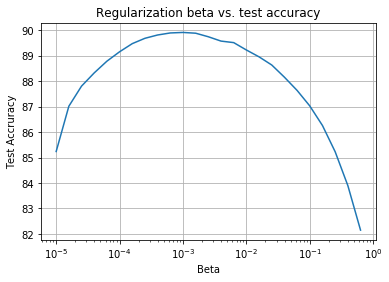

Max accuracy: 89.9% at 0.001000


In [61]:
#print(test_accuracy)
#print(beta_val)
plt.semilogx(beta_val,test_accuracy)
plt.grid(True)
plt.title("Regularization beta vs. test accuracy")
plt.xlabel("Beta")
plt.ylabel("Test Accruracy")
plt.show()
print("Max accuracy: %.1f%% at %f" % (max(test_accuracy),max(beta_val*(test_accuracy == max(test_accuracy)))))

In [74]:
batch_size = 128
image_size = 28
hidden_nodes = 1024

graph = tf.Graph()

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size,image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regu = tf.placeholder(tf.float32)
    
    #Define Variables
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes]))
    
    #Define weights for hidden layer
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes,num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    #feed forward 
    logits = tf.nn.relu(tf.matmul(tf_train_dataset,weights1) + biases1)
    logits = tf.matmul(logits,weights2)+biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) + beta_regu *(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    
    test_logit = tf.nn.relu(tf.matmul(tf_test_dataset,weights1)+biases1)
    test_logit = tf.matmul(test_logit,weights2)+biases2
    test_prediction = tf.nn.softmax(test_logit)
    
    valid_logit = tf.nn.relu(tf.matmul(tf_valid_dataset,weights1)+biases1)
    valid_logit = tf.matmul(valid_logit,weights2)+biases2
    valid_prediction = tf.nn.softmax(valid_logit)
    
    
    
    
        

In [79]:
num_steps = 12001

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (batch_size * step) % (train_labels.shape[0]-batch_size)
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_labels = train_labels[offset:(offset+batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regu : 0.000631}
        #feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : .000631}
        _,l,predictions = session.run([optimizer,loss,train_prediction], feed_dict = feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(),test_labels)) 

Initialized
Minibatch loss at step 0: 565.735229
Minibatch accuracy: 13.3%
Validation accuracy: 32.6%
Minibatch loss at step 500: 155.245895
Minibatch accuracy: 79.7%
Validation accuracy: 78.1%
Minibatch loss at step 1000: 106.734650
Minibatch accuracy: 82.0%
Validation accuracy: 81.2%
Minibatch loss at step 1500: 76.031868
Minibatch accuracy: 86.7%
Validation accuracy: 82.2%
Minibatch loss at step 2000: 54.366955
Minibatch accuracy: 89.1%
Validation accuracy: 83.7%
Minibatch loss at step 2500: 40.541988
Minibatch accuracy: 86.7%
Validation accuracy: 83.5%
Minibatch loss at step 3000: 29.246292
Minibatch accuracy: 85.2%
Validation accuracy: 84.3%
Minibatch loss at step 3500: 21.175112
Minibatch accuracy: 87.5%
Validation accuracy: 86.2%
Minibatch loss at step 4000: 15.744858
Minibatch accuracy: 82.0%
Validation accuracy: 86.7%
Minibatch loss at step 4500: 11.650021
Minibatch accuracy: 87.5%
Validation accuracy: 87.2%
Minibatch loss at step 5000: 8.383613
Minibatch accuracy: 92.2%
Valid

In [77]:
num_steps = 3001
beta_val = [pow(10,i) for i in np.arange(-5,0,0.2)]
test_accuracy = []
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for beta_regu_val in beta_val:
        for step in range(num_steps):
            offset = (batch_size * step) % (train_labels.shape[0]-batch_size)
            batch_dat#print(test_accuracy)
#print(beta_val)
plt.semilogx(beta_val,test_accuracy)
plt.grid(True)
plt.title("Regularization beta vs. test accuracy")
plt.xlabel("Beta")
plt.ylabel("Test Accruracy")
plt.show()
print("Max accuracy: %.1f%% at %f" % (max(test_accuracy),max(beta_val*(test_accuracy == max(test_accuracy)))))a = train_dataset[offset:(offset+batch_size),:]
            batch_labels = train_labels[offset:(offset+batch_size),:]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regu : beta_regu_val}
            #feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
            _,l,predictions = session.run([optimizer,loss,train_prediction], feed_dict = feed_dict)
        test_accuracy.append(accuracy(test_prediction.eval(),test_labels))
        print("Finished for: %f" % beta_regu_val)

Initialized
Finished for: 0.000010
Finished for: 0.000016
Finished for: 0.000025
Finished for: 0.000040
Finished for: 0.000063
Finished for: 0.000100
Finished for: 0.000158
Finished for: 0.000251
Finished for: 0.000398
Finished for: 0.000631
Finished for: 0.001000
Finished for: 0.001585
Finished for: 0.002512
Finished for: 0.003981
Finished for: 0.006310
Finished for: 0.010000
Finished for: 0.015849
Finished for: 0.025119
Finished for: 0.039811
Finished for: 0.063096
Finished for: 0.100000
Finished for: 0.158489
Finished for: 0.251189
Finished for: 0.398107
Finished for: 0.630957


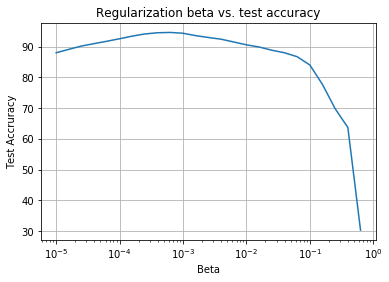

Max accuracy: 94.6% at 0.000631


In [78]:
#print(test_accuracy)
#print(beta_val)
plt.semilogx(beta_val,test_accuracy)
plt.grid(True)
plt.title("Regularization beta vs. test accuracy")
plt.xlabel("Beta")
plt.ylabel("Test Accruracy")
plt.show()
print("Max accuracy: %.1f%% at %f" % (max(test_accuracy),max(beta_val*(test_accuracy == max(test_accuracy)))))

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [80]:
batch_size = 128
image_size = 28
hidden_nodes = 1024

graph = tf.Graph()

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size,image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regu = tf.placeholder(tf.float32)
    
    #Define Variables
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes]))
    
    #Define weights for hidden layer
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes,num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    #feed forward 
    logits = tf.nn.relu(tf.matmul(tf_train_dataset,weights1) + biases1)
    #Dropout takes tensor and keep_prob here keep_prob will be 0.5 we can tune this parameter
    logits = tf.nn.dropout(logits,0.5)
    logits = tf.matmul(logits,weights2)+biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) + beta_regu *(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    
    test_logit = tf.nn.relu(tf.matmul(tf_test_dataset,weights1)+biases1)
    test_logit = tf.matmul(test_logit,weights2)+biases2
    test_prediction = tf.nn.softmax(test_logit)
    
    valid_logit = tf.nn.relu(tf.matmul(tf_valid_dataset,weights1)+biases1)
    valid_logit = tf.matmul(valid_logit,weights2)+biases2
    valid_prediction = tf.nn.softmax(valid_logit)
    
    

In [82]:
num_steps = 10001

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (batch_size * step) % (train_labels.shape[0]-batch_size)
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_labels = train_labels[offset:(offset+batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regu : .000631}
        #feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _,l,predictions = session.run([optimizer,loss,train_prediction], feed_dict = feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(),test_labels)) 

Initialized
Minibatch loss at step 0: 722.574707
Minibatch accuracy: 12.5%
Validation accuracy: 30.8%
Test accuracy: 33.2%
Minibatch loss at step 500: 165.949402
Minibatch accuracy: 74.2%
Validation accuracy: 78.9%
Test accuracy: 86.9%
Minibatch loss at step 1000: 107.553299
Minibatch accuracy: 78.9%
Validation accuracy: 80.7%
Test accuracy: 87.6%
Minibatch loss at step 1500: 76.310005
Minibatch accuracy: 76.6%
Validation accuracy: 81.1%
Test accuracy: 88.2%
Minibatch loss at step 2000: 54.399429
Minibatch accuracy: 85.2%
Validation accuracy: 82.1%
Test accuracy: 89.3%
Minibatch loss at step 2500: 40.778923
Minibatch accuracy: 80.5%
Validation accuracy: 82.6%
Test accuracy: 90.2%
Minibatch loss at step 3000: 29.322638
Minibatch accuracy: 81.2%
Validation accuracy: 83.1%
Test accuracy: 90.4%
Minibatch loss at step 3500: 21.149702
Minibatch accuracy: 82.8%
Validation accuracy: 84.4%
Test accuracy: 91.5%
Minibatch loss at step 4000: 15.847289
Minibatch accuracy: 78.1%
Validation accuracy:

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Let's try 3 layer with dropout and regularization to test out and learning rate decay as well

In [109]:
batch_size = 128
#image_size = 28
hidden_nodes1 = 1024
hidden_nodes2 = 512
hidden_nodes3 = 256
keep_prob = 0.5
num_labels = 10

graph = tf.Graph()

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size,image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regu = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)  # count the number of steps taken.
    
    #Define Variables
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes1],stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([hidden_nodes1]))
    
    #Define weights for hidden layer1
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes1,hidden_nodes2],stddev=np.sqrt(2.0 / (hidden_nodes1))))
    biases2 = tf.Variable(tf.zeros([hidden_nodes2]))
    
    #Define weights for hidden layer2
    weights3 = tf.Variable(tf.truncated_normal([hidden_nodes2,hidden_nodes3],stddev=np.sqrt(2.0 / (hidden_nodes2))))
    biases3 = tf.Variable(tf.zeros([hidden_nodes3]))
    
    #Define weights for hidden layer3
    weights4 = tf.Variable(tf.truncated_normal([hidden_nodes3,num_labels],stddev=np.sqrt(2.0 / (hidden_nodes2))))
    biases4 = tf.Variable(tf.zeros([num_labels]))
    
    #feed forward 
    logits = tf.nn.relu(tf.matmul(tf_train_dataset,weights1) + biases1)
    #Dropout takes tensor and keep_prob here keep_prob will be 0.5 we can tune this parameter
    logits = tf.nn.dropout(logits,keep_prob)
    logits = tf.nn.relu(tf.matmul(logits,weights2)+biases2)
    #logits = tf.nn.dropout(logits,keep_prob)
    logits = tf.nn.relu(tf.matmul(logits,weights3)+biases3)
    #logits = tf.nn.dropout(logits,keep_prob) 
    logits = tf.matmul(logits,weights4)+biases4
    
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels))
    #+ beta_regu *(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)+tf.nn.l2_loss(weights3)+tf.nn.l2_loss(weights4))
    
    learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    
    test_logits = tf.nn.relu(tf.matmul(tf_test_dataset,weights1) + biases1)
    test_logits = tf.nn.relu(tf.matmul(test_logits,weights2)+biases2)
    test_logits = tf.nn.relu(tf.matmul(test_logits,weights3)+biases3) 
    test_logits = tf.matmul(test_logits,weights4)+biases4
    test_prediction = tf.nn.softmax(test_logits)
    
    valid_logits = tf.nn.relu(tf.matmul(tf_valid_dataset,weights1) + biases1)
    valid_logits = tf.nn.relu(tf.matmul(valid_logits,weights2)+biases2)
    valid_logits = tf.nn.relu(tf.matmul(valid_logits,weights3)+biases3) 
    valid_logits = tf.matmul(valid_logits,weights4)+biases4
    valid_prediction = tf.nn.softmax(valid_logits)

In [110]:
num_steps = 20001

with tf.Session(graph = graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (batch_size * step) % (train_labels.shape[0]-batch_size)
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_labels = train_labels[offset:(offset+batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regu : .000631}
        #feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _,l,predictions = session.run([optimizer,loss,train_prediction], feed_dict = feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(),test_labels)) 

Initialized
Minibatch loss at step 0: 3.340060
Minibatch accuracy: 12.5%
Validation accuracy: 10.8%
Test accuracy: 11.3%
Minibatch loss at step 500: 1.397148
Minibatch accuracy: 79.7%
Validation accuracy: 84.0%
Test accuracy: 90.9%
Minibatch loss at step 1000: 1.129487
Minibatch accuracy: 85.2%
Validation accuracy: 84.7%
Test accuracy: 91.5%
Minibatch loss at step 1500: 0.919824
Minibatch accuracy: 85.2%
Validation accuracy: 85.6%
Test accuracy: 92.3%
Minibatch loss at step 2000: 0.737285
Minibatch accuracy: 89.1%
Validation accuracy: 85.9%
Test accuracy: 92.1%
Minibatch loss at step 2500: 0.702466
Minibatch accuracy: 89.1%
Validation accuracy: 86.3%
Test accuracy: 92.8%
Minibatch loss at step 3000: 0.805223
Minibatch accuracy: 85.2%
Validation accuracy: 86.5%
Test accuracy: 93.0%
Minibatch loss at step 3500: 0.569511
Minibatch accuracy: 88.3%
Validation accuracy: 87.2%
Test accuracy: 93.5%
Minibatch loss at step 4000: 0.810280
Minibatch accuracy: 79.7%
Validation accuracy: 86.8%
Test 